In [201]:
import onnxruntime
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [206]:
def overlay_mask(image_np, mask, color, threshold=0.5, alpha=0.3):
    # Convert masks to binary (thresholded)

    print("mask shape:", mask.shape)
    print("image shape:", image_np.shape)

    # Resize masks to original image size
    mask = np.squeeze(mask, axis=0)
    mask = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    print("mask shape:", mask.shape)
    print("image shape:", image_np.shape)
    
    # Apply color map to the mask
    color_mask = image_np.copy()
    color_mask[mask > threshold] = color

    # Overlay mask on original image
    overlay = cv2.addWeighted(image_np, 1 - alpha, color_mask, alpha, 0)

    # Convert to PIL and show
    return overlay

In [207]:
def center_pad_square(image):
    maxdim = max(image.shape)
    padding = np.zeros((maxdim, maxdim, 3), dtype=np.uint8)
    ypad = int((maxdim - image.shape[0])/2)
    xpad = int((maxdim - image.shape[1])/2)
    padding[ypad: ypad + image.shape[0], xpad: xpad + image.shape[1]] = image
    return padding
    

In [208]:
label_to_color = {
    1:(150,255,200),
    2:(0,0,255)
}

Detected: 2 objects
labels: [2 1]
scores: [0.9988171  0.99765295]
shape mask (2, 1, 512, 512)
mask shape: (1, 512, 512)
image shape: (512, 512, 3)
mask shape: (512, 512)
image shape: (512, 512, 3)
mask shape: (1, 512, 512)
image shape: (512, 512, 3)
mask shape: (512, 512)
image shape: (512, 512, 3)


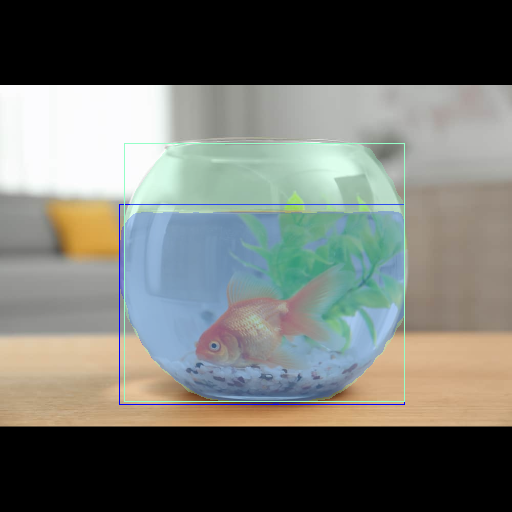

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [209]:
# Load the ONNX model
onnx_path = '2025-03-09_12-29-05/maskrcnn_resnet50_fpn_v2.onnx'

session = onnxruntime.InferenceSession(onnx_path)

# Prepare input
im = Image.open("test_data/fisbowl_test.jpg")
np_image = np.array(im)
np_image = center_pad_square(np_image)
np_image = cv2.resize(np_image, (512,512))
tensor = np_image/255.0
tensor = tensor.astype(np.float32)
tensor = np.expand_dims(tensor, axis=0)
tensor = tensor.transpose(0,3,1,2)

# Run inference
outputs = session.run(None, {"input": tensor})

# Extract outputs
boxes, labels, scores, masks = outputs
print(f"Detected: {len(boxes)} objects")
print(f"labels: {labels}")
print(f"scores: {scores}")
print(f"shape mask {masks.shape}")
mask_images = []

for bbox, label, mask in zip(boxes, labels, masks):
    (x1, y1, x2, y2) = bbox.astype(int)
    color = label_to_color.get(label, (255,0,0))
    np_image = overlay_mask(np_image, mask, color)
    cv2.rectangle(np_image,(x1,y1),(x2,y2),color,1)

overlay_image = Image.fromarray(np_image).convert('RGB')
display(overlay_image)
display(mask)

In [ ]:
# check if there is any overlap between to rectangles 
# if there is